In [1]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import random
import matplotlib.pyplot as plt
import bspline
import bspline.splinelab as splinelab

import jqdatasdk as jq
jq.auth('18132372687', 'zfc17221658')

%matplotlib inline

auth success 


In [2]:
def qlbs_put(S0, K, T, M, mu, sigma, r, N_MC=10000, risk_lambda=0.001):
    
    delta_t = M / T                # time interval
    gamma = np.exp(- r * delta_t)  # discount factor
    
    
    S = pd.DataFrame([], index=range(1, N_MC+1), columns=range(T+1))
    S.loc[:,0] = S0
    RN = pd.DataFrame(np.random.randn(N_MC,T), index=range(1, N_MC+1), columns=range(1, T+1))
    for t in range(1, T+1):
        S.loc[:,t] = S.loc[:,t-1] * np.exp((mu - 1/2 * sigma**2) * delta_t + sigma * np.sqrt(delta_t) * RN.loc[:,t])

    delta_S = S.loc[:,1:T].values - np.exp(r * delta_t) * S.loc[:,0:T-1]
    delta_S_hat = delta_S.apply(lambda x: x - np.mean(x), axis=0)
    X = - (mu - 1/2 * sigma**2) * np.arange(T+1) * delta_t + np.log(S)
    X_min = np.min(np.min(X))
    X_max = np.max(np.max(X))

    p = 4  
    ncolloc = 12

    tau = np.linspace(X_min,X_max,ncolloc)  # These are the sites to which we would like to interpolate
    k = splinelab.aptknt(tau, p) 
    basis = bspline.Bspline(k, p)  

    num_t_steps = T + 1
    num_basis =  ncolloc # len(k) #
    data_mat_t = np.zeros((num_t_steps, N_MC,num_basis ))
    for i in np.arange(num_t_steps):
        x = X.values[:,i]
        data_mat_t[i,:,:] = np.array([ basis(el) for el in x ])
        
    # portfolio value
    Pi = pd.DataFrame([], index=range(1, N_MC+1), columns=range(T+1))
    Pi.iloc[:,-1] = S.iloc[:,-1].apply(lambda x: terminal_payoff(x, K))

    Pi_hat = pd.DataFrame([], index=range(1, N_MC+1), columns=range(T+1))
    Pi_hat.iloc[:,-1] = Pi.iloc[:,-1] - np.mean(Pi.iloc[:,-1])

    # optimal hedge
    a = pd.DataFrame([], index=range(1, N_MC+1), columns=range(T+1))
    a.iloc[:,-1] = 0
    
    reg_param = 1e-3 # free parameter
    for t in range(T-1, -1, -1):
        A_mat = function_A_vec(t, delta_S_hat, data_mat_t, reg_param)
        B_vec = function_B_vec(t, Pi_hat, delta_S_hat, S, data_mat_t, gamma, risk_lambda, r, delta_t)
        phi = np.dot(np.linalg.inv(A_mat), B_vec)
        a.loc[:,t] = np.dot(data_mat_t[t,:,:],phi)
        Pi.loc[:,t] = gamma * (Pi.loc[:,t+1] - a.loc[:,t] * delta_S.loc[:,t])
        Pi_hat.loc[:,t] = Pi.loc[:,t] - np.mean(Pi.loc[:,t])
        
    # reward function
    R = pd.DataFrame([], index=range(1, N_MC+1), columns=range(T+1))
    R.iloc[:,-1] = - risk_lambda * np.var(Pi.iloc[:,-1])

    for t in range(T):
        R.loc[1:,t] = gamma * a.loc[1:,t] * delta_S.loc[1:,t] - risk_lambda * np.var(Pi.loc[1:,t])
        
    # Q function
    Q = pd.DataFrame([], index=range(1, N_MC+1), columns=range(T+1))
    Q.iloc[:,-1] = - Pi.iloc[:,-1] - risk_lambda * np.var(Pi.iloc[:,-1])

    reg_param = 1e-3
    for t in range(T-1, -1, -1):
        C_mat = function_C_vec(t,data_mat_t,reg_param)
        D_vec = function_D_vec(t, Q,R,data_mat_t,gamma)
        omega = np.dot(np.linalg.inv(C_mat), D_vec)

        Q.loc[:,t] = np.dot(data_mat_t[t,:,:], omega)
    return -Q.iloc[:, 0].mean()

In [3]:
def terminal_payoff(ST, K):
    # ST   final stock price
    # K    strike
    payoff = max(K - ST, 0)
    return payoff

# functions to compute optimal hedges
def function_A_vec(t, delta_S_hat, data_mat, reg_param):
    """
    function_A_vec - compute the matrix A_{nm} from Eq. (52) (with a regularization!)
    Eq. (52) in QLBS Q-Learner in the Black-Scholes-Merton article
    
    Arguments:
    t - time index, a scalar, an index into time axis of data_mat
    delta_S_hat - pandas.DataFrame of dimension N_MC x T
    data_mat - pandas.DataFrame of dimension T x N_MC x num_basis
    reg_param - a scalar, regularization parameter
    
    Return:
    - np.array, i.e. matrix A_{nm} of dimension num_basis x num_basis
    """
    X_mat = data_mat[t, :, :]
    num_basis_funcs = X_mat.shape[1]
    this_dS = delta_S_hat.loc[:, t]
    hat_dS2 = (this_dS ** 2).values.reshape(-1, 1)
    A_mat = np.dot(X_mat.T, X_mat * hat_dS2) + reg_param * np.eye(num_basis_funcs)
    
    return A_mat
   
def function_B_vec(t, 
                   Pi_hat, 
                   delta_S_hat, 
                   S, 
                   data_mat,
                   gamma,
                   risk_lambda,
                   r,
                   delta_t):
    """ 
    function_B_vec - compute vector B_{n} from Eq. (52) QLBS Q-Learner in the Black-Scholes-Merton article
    
    Arguments:
    t - time index, a scalar, an index into time axis of delta_S_hat
    Pi_hat - pandas.DataFrame of dimension N_MC x T of portfolio values 
    delta_S_hat - pandas.DataFrame of dimension N_MC x T
    S - pandas.DataFrame of simulated stock prices of dimension N_MC x T
    data_mat - pandas.DataFrame of dimension T x N_MC x num_basis
    gamma - one time-step discount factor $exp(-r \delta t)$
    risk_lambda - risk aversion coefficient, a small positive number
    Return:
    np.array() of dimension num_basis x 1
    """
#     coef = 1. / (2 * gamma * risk_lambda)
    coef = 0
    delta_S = S.loc[:,t+1].values - np.exp(r * delta_t) * S.loc[:,t]
    tmp = Pi_hat.loc[:,t+1] * delta_S_hat.loc[:, t] + coef * delta_S
    X_mat = data_mat[t, :, :]  # matrix of dimension N_MC x num_basis
    B_vec = np.dot(X_mat.T, tmp)
    
    return B_vec

In [4]:
def function_C_vec(t, data_mat, reg_param):
    """
    function_C_vec - calculate C_{nm} matrix from Eq. (56) (with a regularization!)
    Eq. (56) in QLBS Q-Learner in the Black-Scholes-Merton article
    
    Arguments:
    t - time index, a scalar, an index into time axis of data_mat 
    data_mat - pandas.DataFrame of values of basis functions of dimension T x N_MC x num_basis
    reg_param - regularization parameter, a scalar
    
    Return:
    C_mat - np.array of dimension num_basis x num_basis
    """
    X_mat = data_mat[t, :, :]
    num_basis_funcs = X_mat.shape[1]
    C_mat = np.dot(X_mat.T, X_mat) + reg_param * np.eye(num_basis_funcs)
    return C_mat
   
def function_D_vec(t, Q, R, data_mat, gamma):
    """
    function_D_vec - calculate D_{nm} vector from Eq. (56) (with a regularization!)
    Eq. (56) in QLBS Q-Learner in the Black-Scholes-Merton article
    
    Arguments:
    t - time index, a scalar, an index into time axis of data_mat 
    Q - pandas.DataFrame of Q-function values of dimension N_MC x T
    R - pandas.DataFrame of rewards of dimension N_MC x T
    data_mat - pandas.DataFrame of values of basis functions of dimension T x N_MC x num_basis
    gamma - one time-step discount factor $exp(-r \delta t)$
    
    Return:
    D_vec - np.array of dimension num_basis x 1
    """
    X_mat = data_mat[t, :, :]
    D_vec = np.dot(X_mat.T, R.loc[:,t] + gamma * Q.loc[:, t+1])
    
    return D_vec

In [5]:
# The Black-Scholes prices
def bs_put(t, S0, K, r, sigma, T):
    d1 = (np.log(S0/K) + (r + 1/2 * sigma**2) * (T-t)) / sigma / np.sqrt(T-t)
    d2 = (np.log(S0/K) + (r - 1/2 * sigma**2) * (T-t)) / sigma / np.sqrt(T-t)
    price = K * np.exp(-r * (T-t)) * norm.cdf(-d2) - S0 * norm.cdf(-d1)
    return price

def bs_call(t, S0, K, r, sigma, T):
    d1 = (np.log(S0/K) + (r + 1/2 * sigma**2) * (T-t)) / sigma / np.sqrt(T-t)
    d2 = (np.log(S0/K) + (r - 1/2 * sigma**2) * (T-t)) / sigma / np.sqrt(T-t)
    price = S0 * norm.cdf(d1) - K * np.exp(-r * (T-t)) * norm.cdf(d2)
    return price


In [6]:
np.random.seed(42)
# Q1, a1 = qlbs_put(S0=100, K=100, T=24, M=1, mu=.05, sigma=.15, r=.03, N_MC=20000, risk_lambda=0.001)
# price = -Q1.iloc[:, 0].mean()
# hedge_ratio = a1.iloc[:, 0].mean()
# print(price)
# print(bs_put(t=0, S0=100, K=100, r=.03, sigma=.15, T=1))

---

实盘数据部分

In [7]:
df_etf = jq.get_price('510050.XSHG', start_date='2015-01-01', end_date='2020-04-01', frequency='daily', fields=['close']).close

In [8]:
dfName = jq.opt.run_query(
    jq.query(
        jq.opt.OPT_CONTRACT_INFO)
    .filter(
        (jq.opt.OPT_CONTRACT_INFO.underlying_symbol == "510050.XSHG") &
        (jq.opt.OPT_CONTRACT_INFO.is_adjust == 0) & 
        (jq.opt.OPT_CONTRACT_INFO.contract_type == 'PO') & 
        (jq.opt.OPT_CONTRACT_INFO.exercise_date == '2020-03-25')
    )
)

In [39]:
DF = {}
for option_index in range(len(dfName)):
    option = dfName.iloc[option_index]
    code = option.code
    DF[code] = df = jq.opt.run_query(
            jq.query(jq.opt.OPT_DAILY_PRICE.date,
                     jq.opt.OPT_DAILY_PRICE.settle_price).filter(jq.opt.OPT_DAILY_PRICE.code == code)
        )

Option 10002074.XSHG data loaded


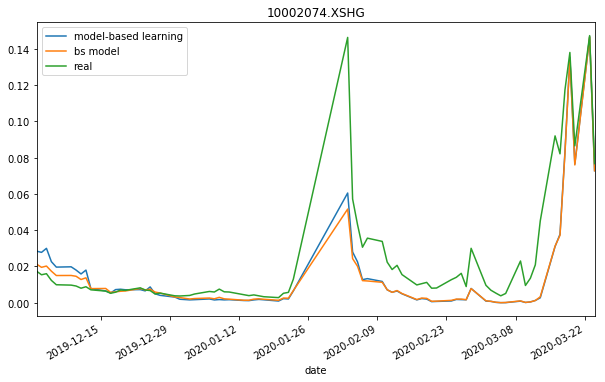

Option 10002075.XSHG data loaded


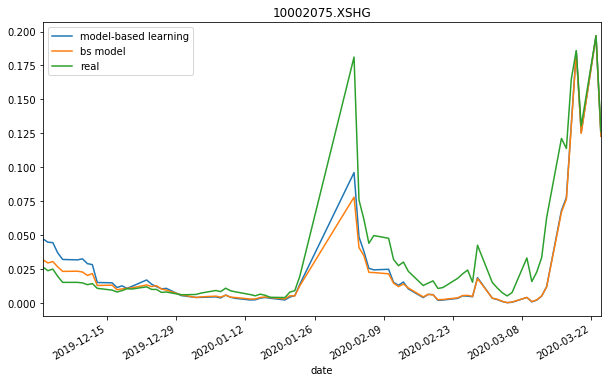

Option 10002076.XSHG data loaded


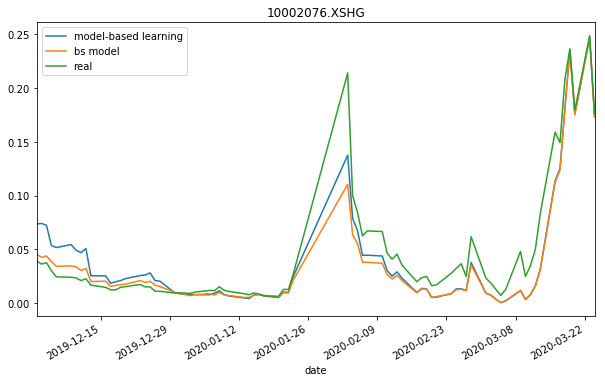

Option 10002077.XSHG data loaded


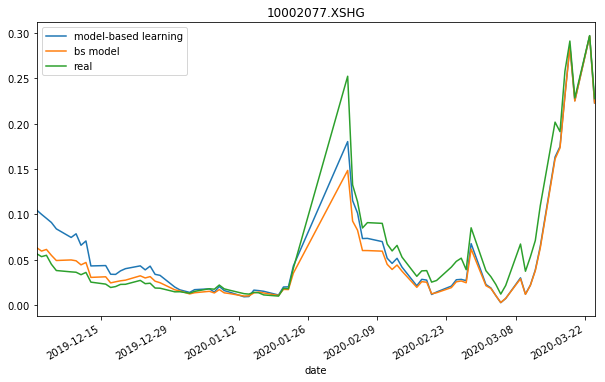

Option 10002078.XSHG data loaded


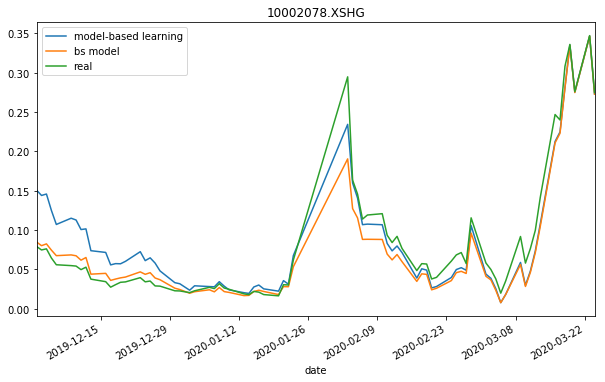

Option 10002079.XSHG data loaded


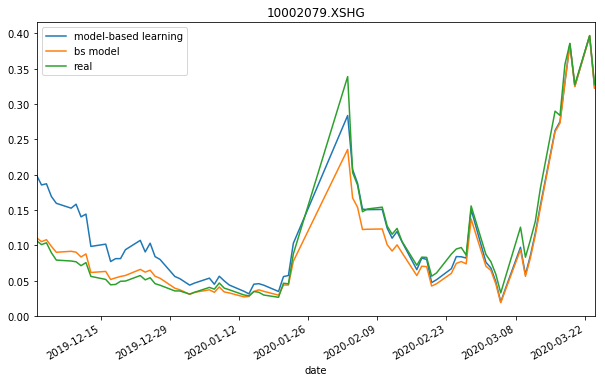

Option 10002080.XSHG data loaded


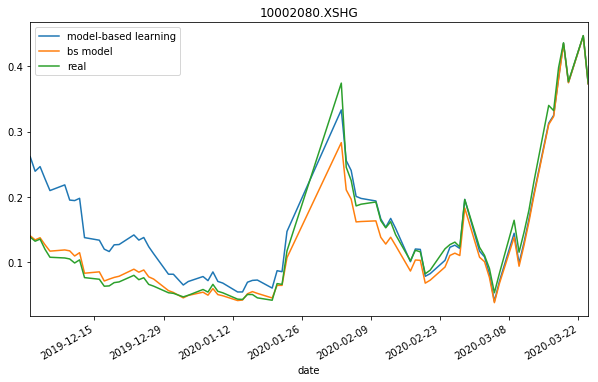

Option 10002081.XSHG data loaded


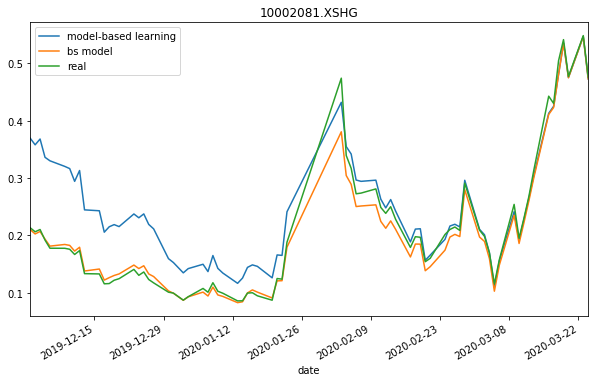

Option 10002082.XSHG data loaded


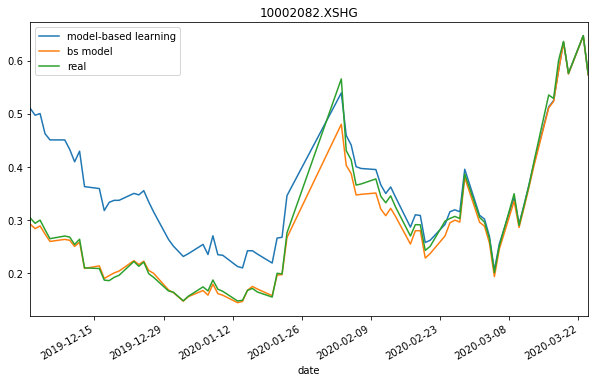

Option 10002106.XSHG data loaded


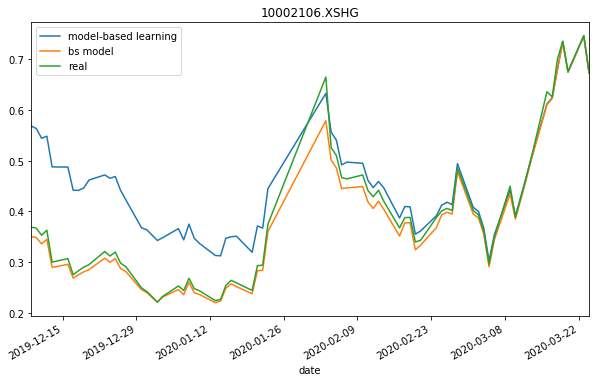

Option 10002114.XSHG data loaded


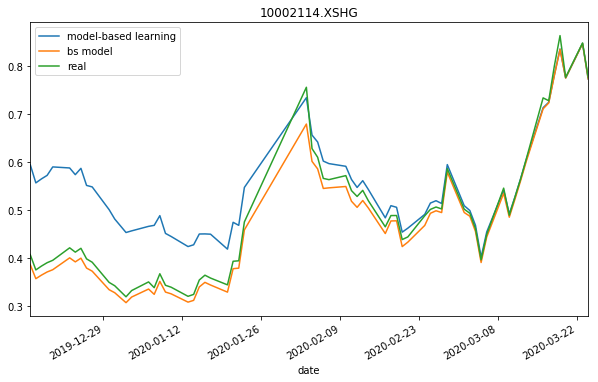

Option 10002212.XSHG data loaded


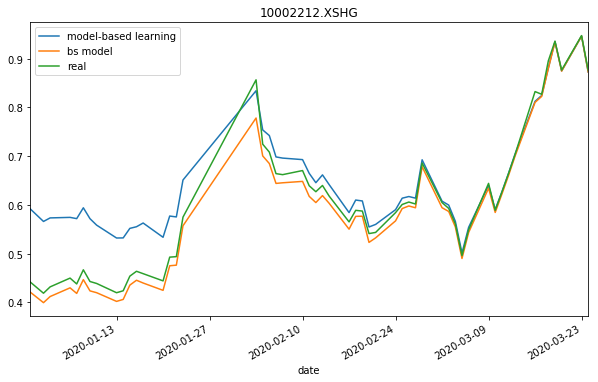

Option 10002287.XSHG data loaded


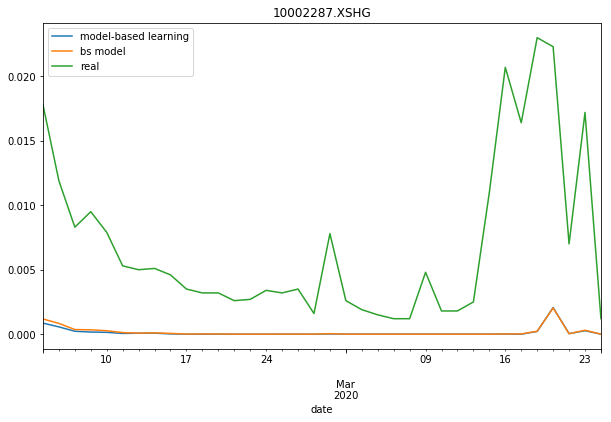

Option 10002288.XSHG data loaded


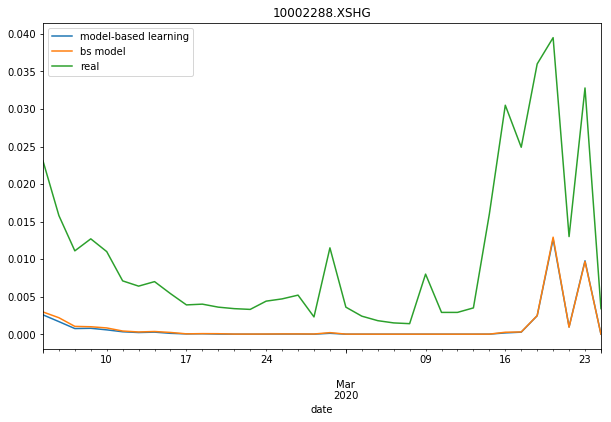

Option 10002289.XSHG data loaded


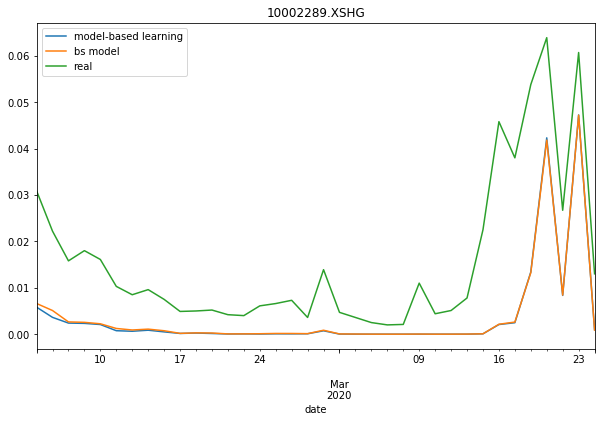

Option 10002290.XSHG data loaded


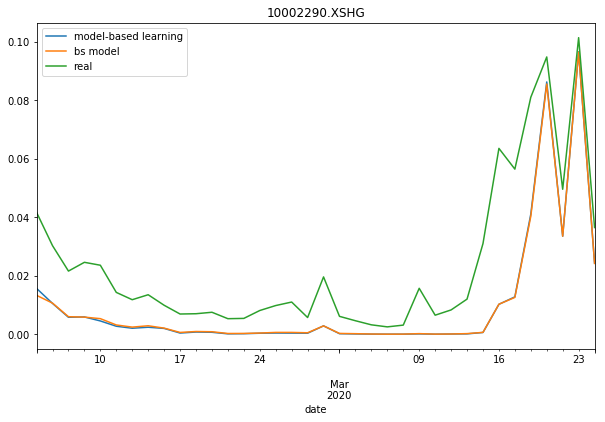

Option 10002395.XSHG data loaded


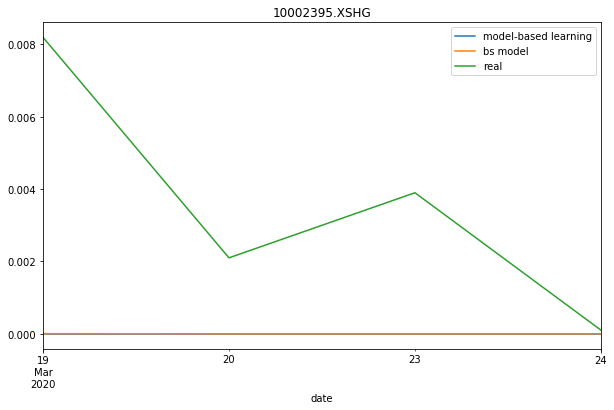

Option 10002396.XSHG data loaded


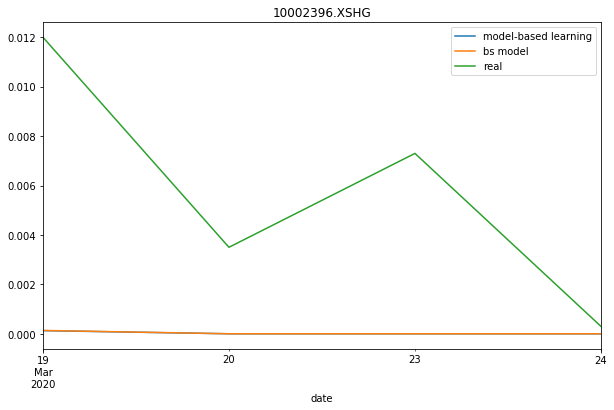

Option 10002418.XSHG data loaded


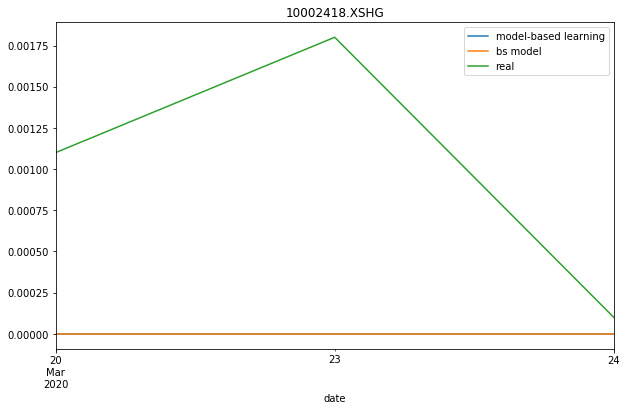

In [45]:
np.random.seed(42)
risk_lambda = 0.1
for option_index in range(len(dfName)):
# for option_index in range(5):
#     option_index = 5
    option = dfName.iloc[option_index]
    code = option.code
    K = option.exercise_price
    df = DF[code].copy()
    print('Option %s data loaded' %code)
    df.set_index('date', inplace=True)
    df['t'] = (pd.to_datetime(option.expire_date) - pd.to_datetime(df.index)).days

    df_price = pd.DataFrame(index=pd.to_datetime(df.index[:-1]), 
                            columns=['model-based learning', 'bs model', 'real'])
    mu = 0.03
    sigma = 0.15
    r = 0.03
    N_MC = 2000
    length = len(df)
    for i in range(len(df)-1):
        M = df['t'][i] / 365
        T = df['t'][i]
        S0 = df_etf.loc[df.index[i]]
        price_qlbs = qlbs_put(S0=S0, K=K, T=T, M=M, mu=mu, sigma=sigma, r=r, N_MC=N_MC, risk_lambda=risk_lambda)
        price_bs = bs_put(length-M, S0, K, r, sigma, length)
        df_price.iloc[i] = [price_qlbs, price_bs, df.iloc[i].settle_price]
    df_price.dropna().plot(title=code,figsize=(10, 6))
    df_price.to_csv('./Data/QLBS_Planning/%s_%s.csv' %(code, risk_lambda))
    plt.savefig('./Data/QLBS_Planning/%s_%s.png' %(code, risk_lambda))
    plt.show()
